In [2]:
import keras
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental import preprocessing

In [3]:
train_dir = r"C:\Users\Admin\Desktop\Breast Cancer Classification\dataset\train\\"
val_dir = r"C:\Users\Admin\Desktop\Breast Cancer Classification\dataset\validation\\"
test_dir = r"C:\Users\Admin\Desktop\Breast Cancer Classification\dataset\test\\"

In [4]:
IMAGE_SIZE = (170,170)
trainDataAll = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                   label_mode = "categorical",
                                                                   image_size = IMAGE_SIZE,
                                                                   shuffle = True )

valDataALL = tf.keras.preprocessing.image_dataset_from_directory(val_dir,
                                                                  label_mode = "categorical",
                                                                  image_size = IMAGE_SIZE,
                                                                  shuffle = False)

testDataALL = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                  label_mode = "categorical",
                                                                  image_size = IMAGE_SIZE,
                                                                  shuffle = False)

Found 771 files belonging to 2 classes.
Found 100 files belonging to 2 classes.
Found 206 files belonging to 2 classes.


In [4]:
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.Rescaling(1. /255)   
])

In [5]:
y_val_labels = []
for images, labels in valDataALL.unbatch(): # unbatch the test data and get images and labels
    y_val_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)

In [6]:
y_test_labels = []
for images, labels in testDataALL.unbatch(): # unbatch the test data and get images and labels
    y_test_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)

In [7]:
class_names = valDataALL.class_names
class_names

['benign', 'malignant']

In [8]:
# Function for Confusion Matrix
import itertools
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15): 
    """
    Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
    # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0] # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])
  
    # Label the axes
    ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

   # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
         plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
             horizontalalignment="center",
             color="white" if cm[i, j] > threshold else "black",
             size=text_size)

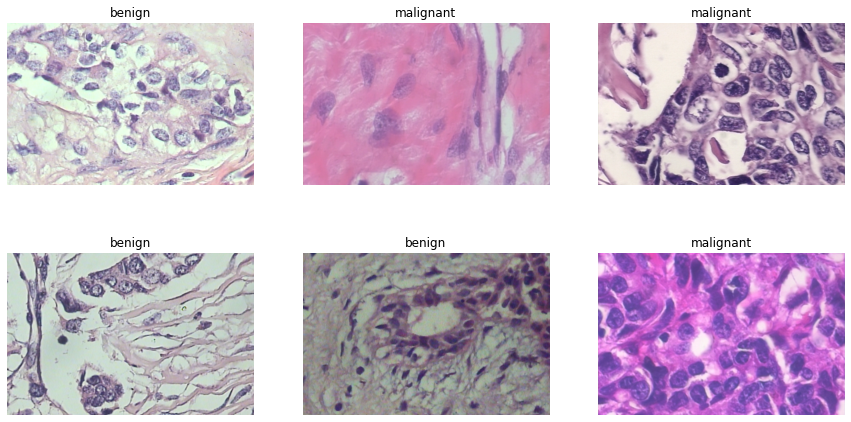

In [8]:
import os
import random
import matplotlib.image as mpimg

plt.figure(figsize = (15,12))
for i in range(6):
    ax = plt.subplot(3,3,i+1)
    class_name = random.choice(class_names)
    filename = random.choice(os.listdir(train_dir + "/" + class_name))
    filepath = train_dir + class_name + "/" + filename
    img = mpimg.imread(filepath)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis(False)

## 1. Training the EfficientNet Pretrained Model

In [7]:
# setup a model and freeze its layers
base_model = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top = False)
base_model.trainable = False
 

#setup model architecture
inputs = layers.Input( shape = (170,170, 3), name = "input_layer") 
x = data_augmentation(inputs)
x = base_model(inputs, training = False)
x = layers.GlobalAveragePooling2D(name = "global_avg_pool")(x)
x = layers.Dropout(0.25)(x) 
outputs = layers.Dense(2, activation = "sigmoid", name = "output_layer")(x)
x = layers.Dropout(0.8)(x) 
model1 = tf.keras.Model(inputs, outputs)

In [8]:
model1.compile(loss = "BinaryCrossentropy",  #"categorical_crossentropy",
             optimizer = tf.keras.optimizers.Adam(),
             metrics = ['accuracy'])

In [10]:
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
filepath = "model_1.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor = "val_accuracy", verbose = 1, save_best_only = True, mode = "max")
callbacks_list = [checkpoint]

In [10]:
history1 = model1.fit(trainDataAll,
                     epochs = 50,
                     batch_size = 32,
                     validation_data = valDataALL,
                     validation_steps = len(valDataALL),
                     callbacks = callbacks_list 
                    )

Epoch 1/50
25/25 [==============================] - 43s 1s/step - loss: 0.6852 - accuracy: 0.5901 - val_loss: 0.6184 - val_accuracy: 0.7300

Epoch 00001: val_accuracy improved from -inf to 0.73000, saving model to model_1.hdf5


C:\Users\Admin\anaconda3\envs\DataSC\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
25/25 [==============================] - 25s 922ms/step - loss: 0.5667 - accuracy: 0.7613 - val_loss: 0.5461 - val_accuracy: 0.7700

Epoch 00002: val_accuracy improved from 0.73000 to 0.77000, saving model to model_1.hdf5
Epoch 3/50
25/25 [==============================] - 29s 1s/step - loss: 0.5116 - accuracy: 0.8003 - val_loss: 0.5056 - val_accuracy: 0.7700

Epoch 00003: val_accuracy did not improve from 0.77000
Epoch 4/50
25/25 [==============================] - 25s 936ms/step - loss: 0.4767 - accuracy: 0.8236 - val_loss: 0.4667 - val_accuracy: 0.8000

Epoch 00004: val_accuracy improved from 0.77000 to 0.80000, saving model to model_1.hdf5
Epoch 5/50
25/25 [==============================] - 28s 1s/step - loss: 0.4489 - accuracy: 0.8184 - val_loss: 0.4420 - val_accuracy: 0.8100

Epoch 00005: val_accuracy improved from 0.80000 to 0.81000, saving model to model_1.hdf5
Epoch 6/50
25/25 [==============================] - 29s 1s/step - loss: 0.4209 - accuracy: 0.8444 - val_loss


Epoch 00041: val_accuracy did not improve from 0.91000
Epoch 42/50
25/25 [==============================] - 28s 1s/step - loss: 0.2334 - accuracy: 0.9131 - val_loss: 0.2784 - val_accuracy: 0.9000

Epoch 00042: val_accuracy did not improve from 0.91000
Epoch 43/50
25/25 [==============================] - 27s 1s/step - loss: 0.2230 - accuracy: 0.9209 - val_loss: 0.2725 - val_accuracy: 0.9100

Epoch 00043: val_accuracy did not improve from 0.91000
Epoch 44/50
25/25 [==============================] - 27s 997ms/step - loss: 0.2216 - accuracy: 0.9183 - val_loss: 0.2712 - val_accuracy: 0.9000

Epoch 00044: val_accuracy did not improve from 0.91000
Epoch 45/50
25/25 [==============================] - 28s 1s/step - loss: 0.2243 - accuracy: 0.9092 - val_loss: 0.2769 - val_accuracy: 0.9100

Epoch 00045: val_accuracy did not improve from 0.91000
Epoch 46/50
25/25 [==============================] - 27s 1s/step - loss: 0.2155 - accuracy: 0.9209 - val_loss: 0.2691 - val_accuracy: 0.9100

Epoch 00046

In [11]:
#loading the save model
from keras.models import load_model
load_model = load_model(r"C:\Users\Admin\Desktop\Breast Cancer Classification\model_1.hdf5")

In [11]:
model1.evaluate(valDataALL)

4/4 [==============================] - 3s 677ms/step - loss: 0.2715 - accuracy: 0.9000


[0.271510511636734, 0.8999999761581421]

In [12]:
y_pred1 = model1.predict(valDataALL)

In [14]:
y_pred1 = load_model.predict(valDataALL)

### 1.1 Evaluation of EfficientNet

In [14]:
from sklearn.metrics import accuracy_score
import numpy as np
sklearn_accuracy = accuracy_score(y_val_labels, np.argmax(y_pred1, axis = 1))
print('Accuracy of EfficientNet on Test Data:', sklearn_accuracy)

Accuracy of EfficientNet on Test Data: 0.9


In [16]:
from sklearn.metrics import classification_report
print(classification_report(y_val_labels, np.argmax(y_pred1, axis = 1), target_names=class_names))

              precision    recall  f1-score   support

      benign       1.00      0.80      0.89        50
   malignant       0.83      1.00      0.91        50

    accuracy                           0.90       100
   macro avg       0.92      0.90      0.90       100
weighted avg       0.92      0.90      0.90       100



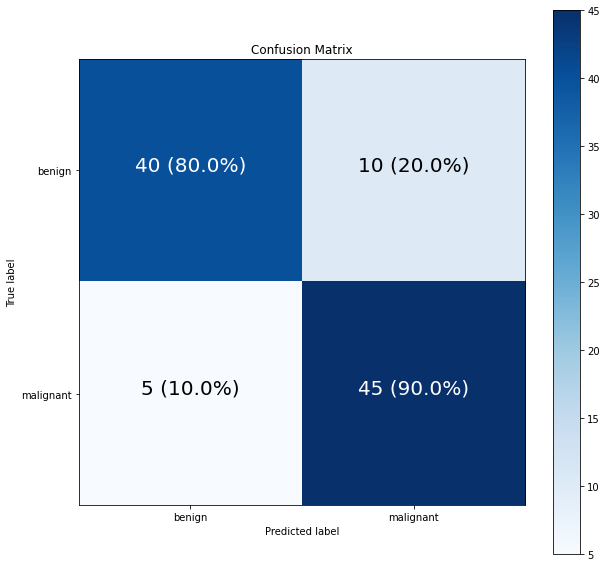

In [16]:
# Confusion Matrix
make_confusion_matrix(y_true=y_val_labels, # ground truth test labels
                          y_pred=np.argmax(y_pred1, axis = 1), # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(10, 10),
                          text_size=20)

## Model Loading and Showing Prediction on Test Samples

In [9]:
load_model = keras.models.load_model(r'C:\Users\Admin\Desktop\Breast Cancer Classification\model_1.hdf5')

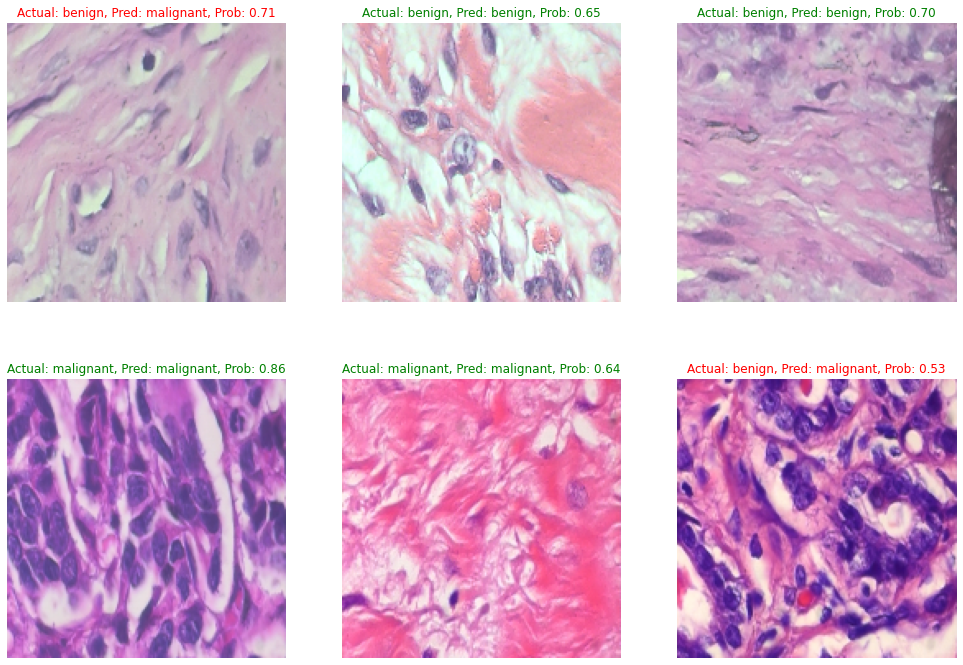

In [13]:
import random
import os

plt.figure(figsize=(17, 12))
for i in range(6):
    class_name = random.choice(class_names)
    filename = random.choice(os.listdir(test_dir + "/" + class_name))
    filepath = test_dir + class_name + "/" + filename
      
    img = tf.io.read_file(filepath)
    img = tf.io.decode_image(img)
    img = tf.image.resize(img, [170,170])
    
    pred_prob = load_model.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 170,170, 3]
    pred_class = class_names[pred_prob.argmax()] # find the predicted class 

    # Plot the image(s)
    plt.subplot(2, 3, i+1)
    plt.imshow(img/255.)
    if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
        title_color = "g"
    else:
        title_color = "r"
    plt.title(f"Actual: {class_name}, Pred: {pred_class}, Prob: {pred_prob.max():.2f}", c=title_color)
    plt.axis(False);